```{contents}
```
## **Dynamic Edge in LangGraph**

A **Dynamic Edge** in LangGraph is a control-flow construct where the **next node is chosen at runtime based on the current state**.
Unlike static edges (fixed transitions), dynamic edges enable **adaptive, data-driven execution paths**, which are essential for intelligent agents, planners, and autonomous workflows.

---

### **1. Motivation**

Real-world LLM systems cannot rely on predetermined pipelines.
They must **adapt** based on:

* Model outputs
* Tool results
* User feedback
* Partial task completion
* Environmental signals

Dynamic edges allow the graph to behave like a **decision-making program** rather than a static pipeline.

---

### **2. Formal Definition**

> A **Dynamic Edge** is an edge whose destination node is determined by a **routing function** evaluated at runtime using the current state.

---

### **3. Static vs Dynamic Edges**

| Property           | Static Edge | Dynamic Edge        |
| ------------------ | ----------- | ------------------- |
| Destination        | Fixed       | Computed at runtime |
| Adaptivity         | None        | High                |
| Supports branching | No          | Yes                 |
| Enables agents     | No          | Yes                 |
| Error recovery     | Limited     | Strong              |

---

### **4. Conceptual Model**

```
         ┌──────────────┐
         │   Router     │
         └──────┬───────┘
                ↓
      ┌─────────┴─────────┐
   search_node        answer_node
```

The router chooses the next node based on the evolving state.

---

### **5. Implementation in LangGraph**

Dynamic edges are created using `add_conditional_edges`.

### **State Definition**

```python
from typing import TypedDict

class State(TypedDict):
    query: str
    decision: str
    result: str
```

### **Router Node**

```python
def router(state: State) -> str:
    if "search" in state["query"]:
        return "search"
    return "answer"
```

### **Graph Construction**

```python
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("router", router)
builder.add_node("search", search_node)
builder.add_node("answer", answer_node)

builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    router,
    {
        "search": "search",
        "answer": "answer",
        END: END
    }
)
```

---

### **6. Execution Flow**

```
Input → Router → (Search OR Answer) → END
```

The graph **self-configures** its path on every invocation.

---

### **7. Advanced Dynamic Routing Patterns**

| Pattern                  | Use Case                        |
| ------------------------ | ------------------------------- |
| Model Routing            | Choose GPT-4 vs GPT-3.5         |
| Tool Selection           | Decide which tool to call       |
| Error Recovery           | Retry / fallback logic          |
| Planner-Executor         | Replan dynamically              |
| Multi-Agent Coordination | Delegate to agent based on task |
| Reflection Loop          | Revise until satisfactory       |

---

### **8. Combining Dynamic Edges with Cycles**

```python
builder.add_edge("observe", "router")  # feedback loop
```

This produces **adaptive autonomous agents**.

---

### **9. Production Controls**

| Concern         | Mechanism         |
| --------------- | ----------------- |
| Infinite loops  | `recursion_limit` |
| Invalid routing | Guarded router    |
| Debugging       | Execution tracing |
| Safety          | Human-in-the-loop |
| Auditability    | State logging     |

---

### **10. Mental Model**

Dynamic edges turn LangGraph from a **workflow engine** into a **decision engine**.

> **Static graph → Program
> Dynamic graph → Intelligent system**


### Demonstration

In [6]:
from typing import TypedDict

class State(TypedDict):
    query: str
    route: str
    result: str

def router_node(state: State):
    if "search" in state["query"].lower():
        return {"route": "search"}
    return {"route": "answer"}

def search_node(state: State):
    return {"result": f"🔍 Searching for: {state['query']}"}

def answer_node(state: State):
    return {"result": f"💡 Answering directly: {state['query']}"}

def route_selector(state: State):
    return state["route"]



In [7]:
from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("router", router_node)
builder.add_node("search", search_node)
builder.add_node("answer", answer_node)

builder.set_entry_point("router")

builder.add_conditional_edges(
    "router",
    route_selector,
    {
        "search": "search",
        "answer": "answer",
    }
)

builder.add_edge("search", END)
builder.add_edge("answer", END)

graph = builder.compile()


In [8]:
result = graph.invoke({"query": "search best laptop", "route": "", "result": ""})
print(result)


{'query': 'search best laptop', 'route': 'search', 'result': '🔍 Searching for: search best laptop'}


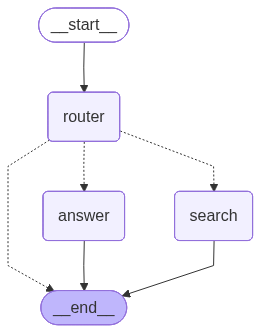

In [4]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())